# Challenge: Boston marathon

Pick a year (post-2012 has more info) and do some clustering. Use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

## Setting up the data

In [93]:
boston = pd.read_csv('Boston_marathon.csv')
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


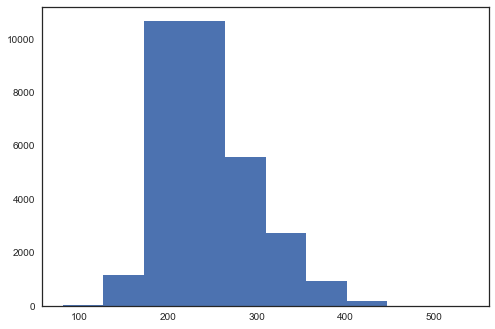

In [94]:
plt.hist(boston.official)
plt.show()

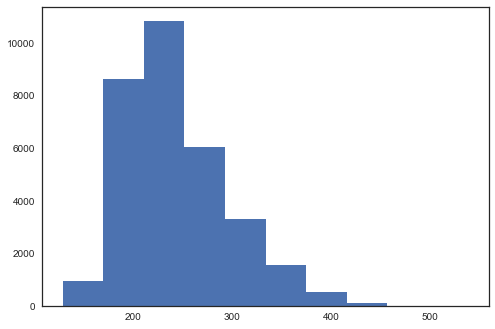

In [95]:
# Removing errors (no sub-2s yet, and definitely not at Boston...)
# Likely to be wheelchair racers
boston = boston.loc[boston.official>128, :]

plt.hist(boston.official)
plt.show()

In [96]:
# Drop variables that aren't useful to cluster on
boston_cont = boston.drop(['name', 'bib', 'state', 'division', 'city', 'country',
                           '40k', 'ctz', 'gender', 'genderdiv', '20k', 'overall'], axis=1)
print(boston_cont.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31940 entries, 1 to 31983
Data columns (total 9 columns):
10k         31940 non-null object
25k         31940 non-null object
age         31940 non-null int64
official    31940 non-null float64
35k         31940 non-null object
pace        31940 non-null float64
30k         31940 non-null object
5k          31940 non-null object
half        31940 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 2.4+ MB
None


In [97]:
# Convert all features to numeric
boston_cont = boston_cont.apply(pd.to_numeric, errors = 'coerce')

# Remove runners with missing observations ('-'), about 300 observations
boston_cont.dropna(inplace=True)


# Need to do this iteratively to avoid comparing strings to ints
#boston_cont = boston_cont.loc[boston['5k']!='-', :]
#boston_cont = boston_cont.loc[boston['10k']!='-', :]
#boston_cont = boston_cont.loc[boston['half']!='-', :]
#boston_cont = boston_cont.loc[boston['25k']!='-', :]
#boston_cont = boston_cont.loc[boston['30k']!='-', :]
#boston_cont = boston_cont.loc[boston['35k']!='-', :]

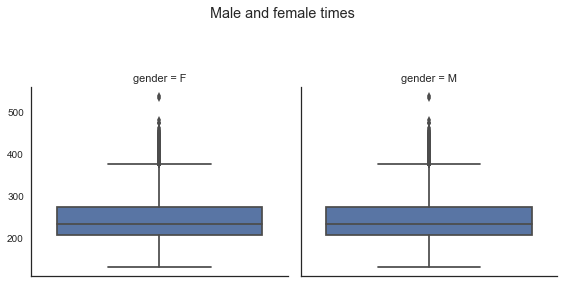

In [98]:
sns.set(style='white')
g = sns.FacetGrid(boston, col="gender", sharey=True, size = 4)
g = g.map(sns.boxplot, y=boston['official'])
plt.suptitle('Male and female times')
plt.subplots_adjust(top=0.7)
plt.show()

In [99]:
boston.official.groupby(boston['gender']).mean()

gender
F    254.920461
M    233.625991
Name: official, dtype: float64

In [100]:
# Create some age categories

def agecats(alist):
    agecategories = []
    for age in alist:
        if age<=24:
            agecategories.append('18-24')
        elif age>24 and age<=29:
            agecategories.append('25-29')
        elif age>29 and age<=34:
            agecategories.append('30-34')
        elif age>34 and age<=39:
            agecategories.append('35-39')
        elif age>39 and age<=44:
            agecategories.append('40-44')
        elif age>44 and age<=49:
            agecategories.append('45-49')
        elif age>49 and age<=54:
            agecategories.append('50-54')
        elif age>54 and age<=59:
            agecategories.append('55-59')
        elif age>59 and age<=64:
            agecategories.append('60-64')
        else:
            agecategories.append('64+')
    return agecategories

# Set age categories to categorical and order (for boxplot)
category_pd = pd.Series(agecats(list(boston.age)), dtype="category")
print(type(category_pd))
category_pd = category_pd.cat.set_categories(['18-24', '25-29', '30-34','35-39', '40-44',
                                  '45-49', '50-54','55-59','60-64',
                                  '64+'], ordered=True)
boston['age_cats']=category_pd

# Set gender to categories
boston['gender'] = boston['gender'].astype('category')

<class 'pandas.core.series.Series'>


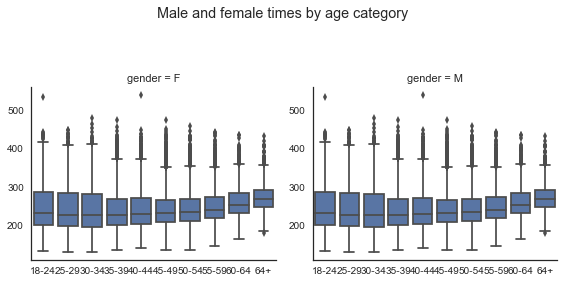

In [101]:
sns.set(style='white')
g = sns.FacetGrid(boston, col="gender", sharey=False, size = 4)
g = g.map(sns.boxplot, y=boston['official'], x=boston['age_cats'])
plt.suptitle('Male and female times by age category')
plt.subplots_adjust(top=0.7)
plt.show()

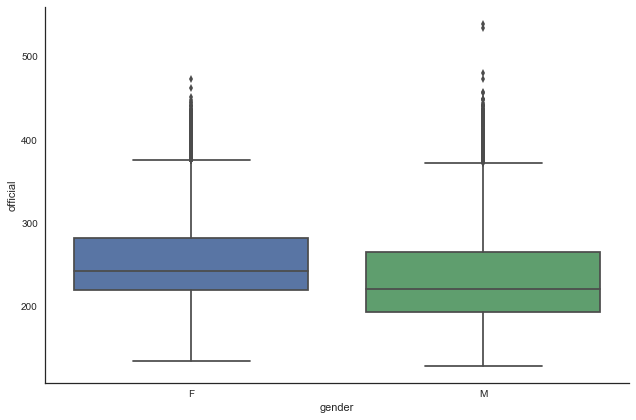

In [10]:
sns.factorplot(kind='box',
               y='official',
               x='gender',         
               data=boston,   
               size=6,                  
               aspect=1.5,         
               legend_out=False)

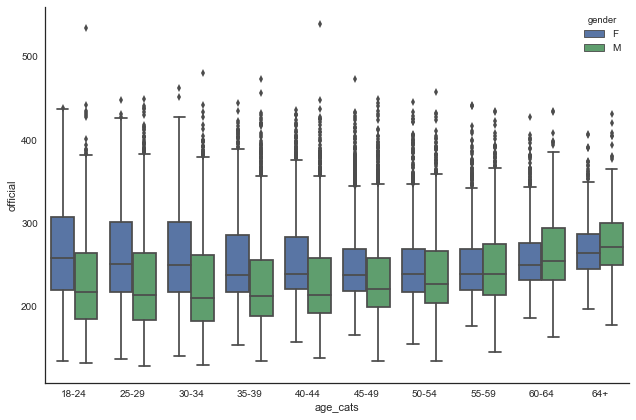

In [11]:
sns.factorplot(kind='box',
               y='official',
               x = 'age_cats',
               hue='gender',         
               data=boston,   
               size=6,                  
               aspect=1.5,         
               legend_out=False)

In [102]:
from sklearn import preprocessing
from sklearn.model_selection import KFold


# Normalize continuous variables
X = preprocessing.normalize(boston_cont, axis=0)

## Cluster 1: A first attempt

In [143]:
# Initializing and fitting KMeans
km = KMeans(n_clusters=6, random_state=42)
clusters = km.fit(X)


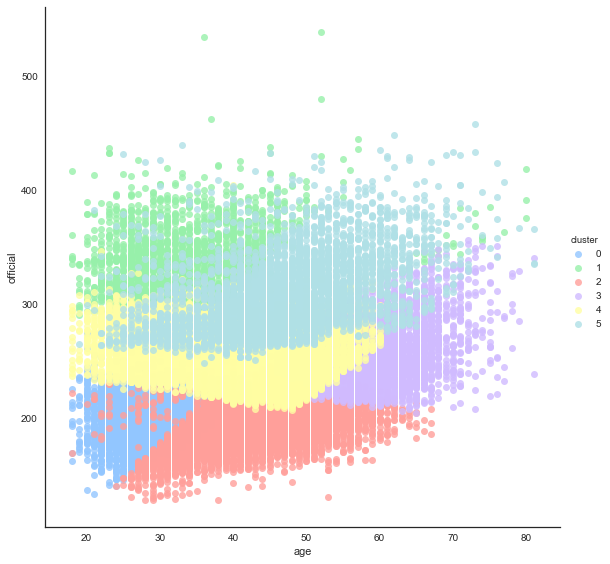

In [59]:
# Adding clusters onto dataset for visualization
boston_clusters = boston_cont.loc[:,:]
boston_clusters['cluster']=km.fit_predict(X)

sns.lmplot(y='official', x='age', hue='cluster', data=boston_clusters,
           palette='pastel', fit_reg=False, ci=False, size=8)
plt.show()

In [60]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

# Calculating silhouette score
labels = clusters.labels_

score = metrics.silhouette_score(X, labels, metric='euclidean', sample_size = 5000)
print(score)

0.42929673557316583


This is not a particularly good clustering model. The silhouette score is low and the clusters do not seem to have much information in the final time/ age space. There are a couple of possibilities why this is happening:
- All the intermediate times (5k, 10k, half, 25k, 30k) are highly correlated with the final time. I can perform PCA to reduce the feature set, instead for ease of use I will only include final time and age.
- I had to omit some useful binary data (gender). This can be accounted for by splitting the sample into male and female and then looking for clusters.
- It is possible that KMeans isn't the most appropriate clustering method
- There is of course some scope to play with the number of clusters


## Cluster 2: Optimizing on number of clusters

In [136]:
cluster_number = range(2,18,2)
print(cluster_number)

range(2, 18, 2)


In [137]:
for i in range(2,18,2):
    km = KMeans(n_clusters=i, random_state=42)
    clusters = km.fit(X)
    labels = clusters.labels_
    score = metrics.silhouette_score(X, labels, metric='euclidean', sample_size = 5000)
    print("Model with {} clusters: score {}".format(i, score))

Model with 2 clusters: score 0.472511693644122
Model with 4 clusters: score 0.3418999627000266
Model with 6 clusters: score 0.32693798545732516
Model with 8 clusters: score 0.31997200550918287
Model with 10 clusters: score 0.2982190595717544
Model with 12 clusters: score 0.29652614806424454
Model with 14 clusters: score 0.29225955552862226
Model with 16 clusters: score 0.2834813758492715


This isn't particularly helpful in choosing k. What is likely happening is that as the clusters get smaller the mean distance between x and other points in the cluster declines (a) falls more than the decline between x and points in the closet cluster, hence the continuous decline. 

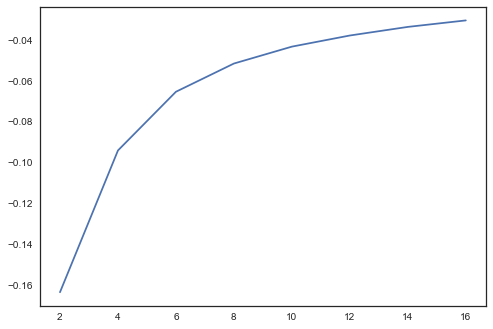

In [147]:
# Trying the elbow method using score

# k means determine k
distortions = []
K = range(2,18,2)
for k in K:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    distortions.append(km.score(X))

plt.plot(K, distortions)
plt.show()


        

6 therefore looks like a goodd elbow to choose.

## Cluster 3: The trimmed model

In [119]:
# Reducing feature space
boston_trim = boston_cont.loc[:, ['official', 'age']]

# Normalize
X_trim = preprocessing.normalize(boston_trim, axis=0)

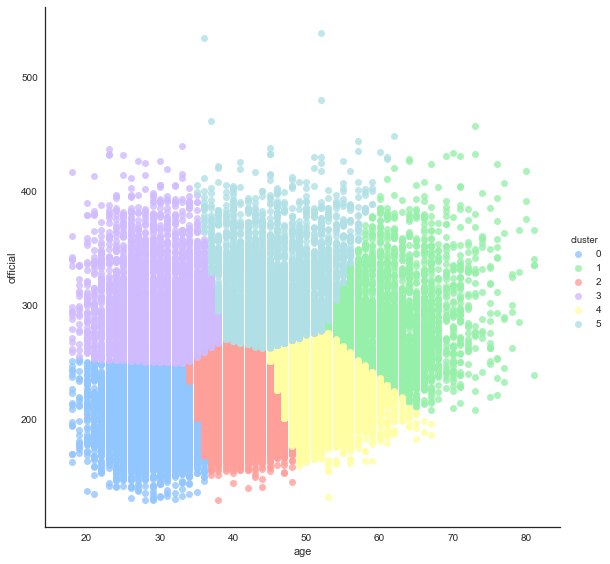

In [120]:
# Trying KMeans again
km = KMeans(n_clusters=6, random_state=42)
clusters = km.fit(X_trim)

# Adding clusters onto dataset for visualization
boston_clusters = boston_trim.loc[:,:]
boston_clusters['cluster']=km.fit_predict(X_trim)

sns.lmplot(y='official', x='age', hue='cluster', data=boston_clusters,
           palette='pastel', fit_reg=False, ci=False, size=8)
plt.show()

In [65]:
# Calculating silhouette score
labels = clusters.labels_

score = metrics.silhouette_score(X_trim, labels, metric='euclidean', sample_size = 10000)
print(score)

0.34994928934182257


Trimming the feature space therefore did not improve the model.

## Cluster 4: Splitting by gender and then clustering

In [121]:
# Create split samples on gender
boston_male = boston_cont.loc[boston.gender=='M', :]
boston_female = boston_cont.loc[boston.gender=='F', :]

# Normalize
X_m = preprocessing.normalize(boston_male, axis=0)
X_f = preprocessing.normalize(boston_female, axis=0)

In [122]:
print("Male count: ", len(X_m))
print("Female count: ", len(X_f))


Male count:  17456
Female count:  14160


In [134]:
# Male
kmM = KMeans(n_clusters=6, random_state=42)
clustersM = kmM.fit(X_m)

# Female
kmF = KMeans(n_clusters=6, random_state=42)
clustersF = kmF.fit(X_f)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


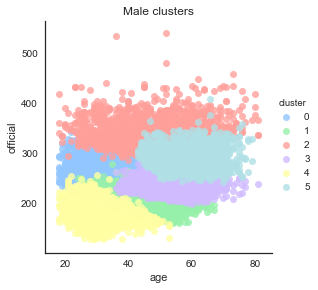

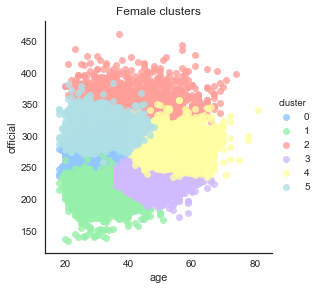

In [133]:
## Adding clusters onto dataset for visualization
boston_male['cluster']=kmM.fit_predict(X_m)
boston_female['cluster']=kmF.fit_predict(X_f)

sns.lmplot(y='official', x='age', hue='cluster', data=boston_male,
           palette='pastel', fit_reg=False, ci=False, size=4)
plt.title("Male clusters")
plt.show()
sns.lmplot(y='official', x='age', hue='cluster', data=boston_female,
           palette='pastel', fit_reg=False, ci=False, size=4)
plt.title("Female clusters")
plt.show()

In [135]:
# Calculating silhouette score
labelsM = clustersM.labels_
labelsF = clustersF.labels_

scoreM = metrics.silhouette_score(X_m, labelsM, metric='euclidean', sample_size = 5000)
print("Male score:", score)

scoreF = metrics.silhouette_score(X_f, labelsF, metric='euclidean', sample_size = 5000)
print("Female score:", score)

Male score: 0.34994928934182257
Female score: 0.34994928934182257


So no great improvement unfortunately.

## Conclusion

The clusters here are not particularly useful. A couple of thoughts on this:
1. The clustering is unlikely to find relationships that weren't available from basic groupings (e.g. patterns in terms of age and gender). Since all the race measurements are strongly correlated these don't add much additional information. Using splits (the difference between 5km intervals at various stages of the race) could add some more depth (e.g. fatigue towards the end, also female runners tend to pace a bit better than male runners). However, faster runners generally are able to hold a more consistant pace - so the cluster is still likely to be based on final time.
2. It is unclear how this kind of clustering is useful. It has little to no predictive value - possibly the splits, age and gender can be used to predict race finish times, but these are only known during the race (and there are better methods for this).  